In [1]:
!pip install --upgrade gdown
!gdown 1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
!tar -xzf genres.tar.gz

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
From (redirected): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3&confirm=t&uuid=41d70f39-5f39-44f7-9e99-63473bef150b
To: /content/genres.tar.gz
100% 1.23G/1.23G [00:15<00:00, 81.2MB/s]


In [5]:
from pathlib import Path

data_dir = Path('genres/')
assert data_dir.exists()

wav_fns = list(data_dir.rglob('*.wav')) # recursive
len(wav_fns)

1000

In [9]:
import torchaudio
import IPython.display as ipd

wav_fn = wav_fns[300]
y, sr = torchaudio.load(wav_fn)

print(wav_fn)
ipd.Audio(y, rate= sr)

genres/metal/metal.00036.wav


In [16]:
resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=16000)
resample_y = resampler(y)
ipd.Audio(resample_y, rate= 16000)

In [21]:
wav_fn.stem.split('.')[0], wav_fn.parent.name

('metal', 'metal')

In [45]:
import random
from tqdm.auto import tqdm

class Dataset:
  def __init__(self, data_dir, target_sr=16000, is_test=False):
    self.data_dir = Path(data_dir)
    self.is_test = is_test

    self.wav_fns = list(self.data_dir.rglob('*.wav'))
    self.wav_fns.sort() # sort before shuffling
    random.seed(0) # fix random seed
    random.shuffle(self.wav_fns)# shuffle list

    assert len(self.wav_fns) > 100

    self.orig_freq = 22050
    self.target_sr = target_sr
    self.resampler = torchaudio.transforms.Resample(orig_freq=self.orig_freq, new_freq=target_sr)

    self.audio_label_pairs = self.load_audio()
    self.class_names = self.make_class_vocab()
    self.slice_dur = 2
    self.slice_samples = self.slice_dur * self.target_sr

    # self.labels = self.load_label()

  def load_audio(self):
    audios = []
    selected_fns = self.wav_fns[800:] if self.is_test else self.wav_fns[:800]
    for wav_fn in tqdm(selected_fns):
      y, sr = torchaudio.load(wav_fn)
      assert sr == self.orig_freq, f'SR has to besame with expected frequency {self.orig_freq}'
      y = self.resampler(y)
      audios.append([y, wav_fn.parent.name])
    return audios

  def make_class_vocab(self):
    class_names = [l for a, l in self.audio_label_pairs]
    # class_names = [pair[1] for pair in self.audio_label_pairs]
    class_names = sorted(list(set(class_names)))
    return class_names

  # Dataset class에 꼭 필요한 두가지: __len__, __getitem__
  def __len__(self):
    return len(self.audio_label_pairs)

  def __getitem__(self, idx:int):
    # dataset[idx] 을 불렀을 때 호출되는 함수
    # idx-th 아이템을 반환해주는 함수
    audio, label = self.audio_label_pairs[idx]

    # string이 아닌 텐서로 반환해줄 수 있도록 변환
    num_samples = audio.shape[1]
    slice_end = num_samples - self.slice_samples
    slice_start = random.randint(0, slice_end-1) #randint는 끝점 포함


    return audio[0, slice_start:slice_start+self.slice_samples], self.class_names.index(label)

dataset = Dataset('genres/', is_test=False)
testset = Dataset('genres/', is_test=True)
dataset.class_names,  dataset[0]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(['blues',
  'classical',
  'country',
  'disco',
  'hiphop',
  'jazz',
  'metal',
  'pop',
  'reggae',
  'rock'],
 (tensor([ 0.1583,  0.1061,  0.0775,  ..., -0.4237,  0.3017,  0.3733]), 4))

In [44]:
y, l = testset[0]
ipd.Audio(y, rate=16000)

In [32]:
# check audio length
set([a.shape[1] for a, l in dataset.audio_label_pairs])

{480003, 480128, 480214, 483222, 484499, 487692, 490383}

## torch.utils.data.DataLoader

- 자동으로 dataset의 getitem을 호출해서 하나의 텐서로 묶어줌
  - 텐서로 변환하는 함수: collate_fn
  - 매 배치마다 어떤 idx로 dataset getitem을 호출할지 자동으로 결정
    - shuffle=True면 자동으로 셔플링된 샘플 호출
    - 매 epoch마다 shuffle 순서는 초기화

In [46]:
# use DataLoader

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in train_loader:
  print(batch)
  break


[tensor([[-2.4294e-01, -2.1801e-01, -2.9576e-01,  ..., -1.0884e-01,
         -1.3876e-01, -8.8421e-02],
        [ 1.2745e-01,  1.0328e-01,  4.6968e-02,  ..., -3.4131e-02,
         -5.1088e-02, -6.8797e-02],
        [-6.4607e-02, -6.2064e-02, -7.8858e-02,  ...,  7.1196e-02,
          6.5457e-02,  4.8115e-02],
        ...,
        [-4.3610e-02, -7.0954e-02, -8.7226e-02,  ..., -1.1743e-01,
         -1.2344e-01, -1.2994e-01],
        [-1.6154e-02, -7.7879e-03, -4.1737e-03,  ..., -1.9141e-06,
          3.7396e-05,  8.2140e-06],
        [-1.2061e-02, -3.0876e-02, -2.7042e-02,  ...,  3.9866e-03,
          3.3451e-03,  8.2086e-03]]), tensor([3, 2, 8, 5, 3, 2, 2, 4, 0, 2, 7, 5, 2, 0, 8, 1, 9, 8, 2, 0, 9, 2, 7, 0,
        1, 4, 4, 8, 6, 3, 1, 1])]


In [47]:
audios, labels = batch
audios.shape, labels.shape

(torch.Size([32, 32000]), torch.Size([32]))

## Make model
- Mel Spectrogram Converter
- nn.Linear?

In [52]:
import torch
import torch.nn as nn

class MelDbConverter(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mel_conv = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80,
                                                     sample_rate=16000)
    self.db_conv = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db_conv(self.mel_conv(x)) / 100


class Model(nn.Module):
  def __init__(self, dim=128, num_out=10):
    super().__init__() # nn.Module init

    self.spec = MelDbConverter()
    self.layers = nn.Sequential(
        nn.Linear(5040, dim),
        nn.ReLU(),
        nn.Linear(dim, dim),
        nn.ReLU(),
        nn.Linear(dim, dim),
        nn.ReLU(),
        nn.Linear(dim, num_out)
    )

  def forward(self, x):
    spec = self.spec(x)
    flattened_spec = spec.reshape(spec.shape[0], -1)
    logit = self.layers(flattened_spec)
    prob = logit.softmax(dim=-1)
    return prob


model = Model()
model(audios)


tensor([[0.0949, 0.0950, 0.0977, 0.1085, 0.0980, 0.1028, 0.0984, 0.1002, 0.1000,
         0.1044],
        [0.0948, 0.0953, 0.0975, 0.1089, 0.0982, 0.1026, 0.0983, 0.1003, 0.0998,
         0.1044],
        [0.0960, 0.0952, 0.0980, 0.1080, 0.0977, 0.1025, 0.0980, 0.1002, 0.1005,
         0.1039],
        [0.0953, 0.0954, 0.0983, 0.1085, 0.0977, 0.1020, 0.0979, 0.1009, 0.1001,
         0.1039],
        [0.0946, 0.0955, 0.0978, 0.1082, 0.0980, 0.1028, 0.0986, 0.1000, 0.1002,
         0.1044],
        [0.0950, 0.0948, 0.0979, 0.1084, 0.0985, 0.1024, 0.0989, 0.0997, 0.1001,
         0.1043],
        [0.0953, 0.0955, 0.0978, 0.1082, 0.0979, 0.1026, 0.0985, 0.0997, 0.1000,
         0.1044],
        [0.0950, 0.0952, 0.0977, 0.1087, 0.0982, 0.1026, 0.0983, 0.1003, 0.1002,
         0.1039],
        [0.0949, 0.0947, 0.0981, 0.1088, 0.0985, 0.1021, 0.0989, 0.1000, 0.0999,
         0.1041],
        [0.0948, 0.0949, 0.0978, 0.1090, 0.0984, 0.1021, 0.0990, 0.0993, 0.1004,
         0.1042],
        [0

In [59]:
from tqdm.auto import tqdm

device = 'cuda'
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters())

loss_record = []
n_epoch = 50

for epoch in range(n_epoch):
  for batch in tqdm(train_loader, leave=False):
    audio, label = batch
    prob = model(audio.to(device))
    loss = -torch.log(prob[torch.arange(len(label)), label]).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

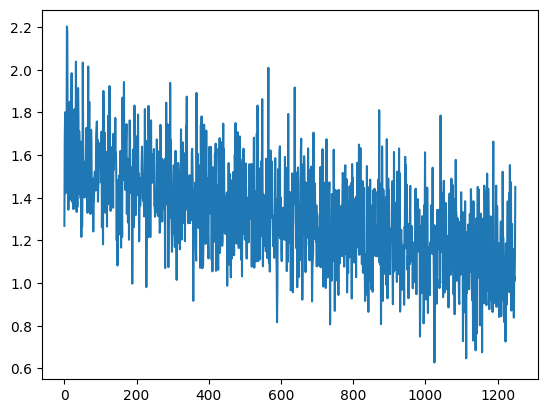

In [58]:
import matplotlib.pyplot as plt

plt.plot(loss_record)

In [76]:
y, l = testset[2]
y = y.unsqueeze(0)
print(y.shape)

ipd.display(ipd.Audio(y, rate=16000))

torch.Size([1, 32000])


In [77]:
torch.set_printoptions(sci_mode=False)

model = model.to('cpu')
model.eval()
prob = model(y)
selected_idx = prob.argmax(dim=-1)
dataset.class_names[selected_idx], prob[0, selected_idx]

('jazz', tensor([0.5900], grad_fn=<IndexBackward0>))

In [69]:
dataset.class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']